In [3]:
from netCDF4 import Dataset
import numpy as np
from math import sin, cos, pi, sqrt
import cdsapi
import os
from netCDF4 import Dataset
from scipy.interpolate import NearestNDInterpolator, interp2d
import pickle
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy.ma as ma
from tqdm import trange
from pyproj import Proj, transform
from scipy import spatial
import datetime
import Mask
import dateutil.parser

In [4]:
def vectors(year):
    
    '''Input year as string to get daily ice motion vectors'''
    
    directory = '/home/robbie/Dropbox/Modelling/vectors/'
    file = 'icemotion_daily_nh_25km_'
    ext = '.nc'
    data = Dataset(directory+file+year+ext)
    return(data)

data = vectors("2016")

x = np.array(data['x'])

x_grid = np.array([x,]*361)

y = np.array(data['y'])

y_grid = np.array([y,]*361).T

EASE_Proj = Proj(init='epsg:3408')
WGS_Proj = Proj(init='epsg:4326')

def xy_to_lonlat(x,y):
    lon,lat = transform(EASE_Proj,WGS_Proj,x,y)
    return(lon,lat)

def lonlat_to_xy(lon,lat):
    x,y = transform(WGS_Proj,EASE_Proj,lon,lat)
    return(x,y)

def merge(list1, list2): 
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))] 
    return merged_list 

def reverser(s):
    d = dateutil.parser.parse(s)
    return d

def interpolator(point,my_data):
    
    """ Docstring"""

    interpolator = NearestNDInterpolator((x_grid.ravel(),y_grid.ravel()),my_data.ravel())

    interp_value = interpolator(point)

    return(interp_value)

# Make a coarse grid of points to initiate ice parcels at. Every tenth point in the EASE grid should do it

(361, 361)


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


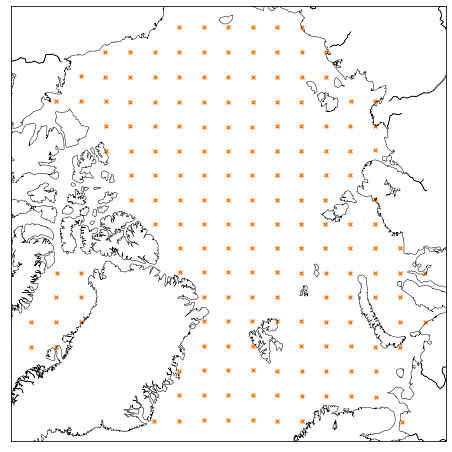

<built-in function len>


In [72]:
my_mask = Mask.get('mask')
print(my_mask.shape)

point_spacing = 10

x_inits = []
y_inits = []

numlist = np.arange(0,361,point_spacing)
for x_index in numlist:
    for y_index in numlist:
        
        if my_mask[x_index,y_index] in [2,3,4,6,7,8,9,10,11,12,13,15]:
        
            x_inits.append(x_grid[x_index,y_index])
            y_inits.append(y_grid[x_index,y_index])

lonlist,latlist = [], []
for i,j in zip(x_inits,y_inits):
    coord = xy_to_lonlat(i,j)
    lonlist.append(coord[0])
    latlist.append(coord[1])
    
    
plt.figure(figsize=(10,8))

m = Basemap(projection='npstere',boundinglat=70,lon_0=360,resolution='l')
m.drawcoastlines(linewidth=0.5)
m.scatter(180,90,latlon=True,marker='x',s=5)
m.scatter(lonlist,latlist,latlon=True,marker='x',s=15)

plt.show()

print(len)


In [74]:
def make_tracks(year,lonlist,latlist,startday=0):

    tracks_dict = {}

    u_data = pickle.load(open('vectors/'+str(year)+'_winter_u.p',"rb"))
    v_data = pickle.load(open('vectors/'+str(year)+'_winter_v.p',"rb"))


    for lon, lat in zip(lonlist,latlist):

        loc = lonlat_to_xy(lon,lat)

        locs = []
        timestamps = []

        for day in range(startday,182):

            if day == 182:
                break

            u_field = u_data[day]
            v_field = v_data[day]

            np.ma.filled(u_field,fill_value=-9999.0)

            u_vel = interpolator(loc,u_field)
            v_vel = interpolator(loc,v_field)

            if (u_vel != -9999.0):

                u_dis = u_vel * 864
                v_dis = v_vel * 864

                loc = (loc[0]+u_dis,
                       loc[1]+v_dis)

                date = (datetime.datetime(year=int(year),
                                         month=10,
                                         day=1)            +        datetime.timedelta(days=day)).date()

                locs.append(loc)
                timestamps.append(date)
            else:
                break

        if len(locs) > 10:
            tracks_dict[(lon,lat)]=(locs,timestamps)
            print(lon,lat)
            print(len(locs))
    return(tracks_dict)

all_tracks = {}
for year in np.arange(2010,2019,1):
    print(year)
    all_tracks[year] = []
    for startday in np.arange(0,180,7):
        tracks = make_tracks(year,lonlist,latlist,startday=startday)
        all_tracks[year].append(tracks)

    pickle.dump(all_tracks[year], open( "all_tracks_"+str(year)+".p", "wb" ) )
pickle.dump(all_tracks, open( "all_tracks.p", "wb" ) )

2010
-11.309932474020213 78.48593598685768
77
0.0 80.97348408222669
77
-18.43494882292201 82.86668398705388
37
0.0 83.2331798989048
77
18.43494882292201 82.86668398705388
54
33.690067525979785 81.86518927289154
41
-26.56505117707799 84.95761379906006
182
0.0 85.49024393885045
122
26.56505117707799 84.95761379906006
103
45.0 83.62059331168996
118
-63.43494882292201 84.95761379906006
182
-45.0 86.811532602448
182
0.0 87.74555856159556
182
45.0 86.811532602448
182
63.43494882292201 84.95761379906006
182
71.56505117707799 82.86668398705388
182
-90.0 83.2331798989048
182
-90.0 85.49024393885045
182
-90.0 87.74555856159556
182
180.0 90.0
182
90.0 87.74555856159556
182
90.0 85.49024393885045
182
90.0 83.2331798989048
182
-104.03624346792648 80.69507737872395
182
-108.43494882292201 82.86668398705388
182
-116.56505117707799 84.95761379906006
182
-135.0 86.811532602448
182
180.0 87.74555856159556
182
135.0 86.811532602448
182
116.56505117707799 84.95761379906006
182
108.43494882292201 82.866683

171.86989764584402 74.00785911208101
168
164.05460409907712 73.53184955763831
168
156.80140948635182 72.76690843213845
168
-15.945395900922854 73.53184955763831
65
-9.462322208025617 76.25471507761534
65
-11.309932474020213 78.48593598685768
103
0.0 80.97348408222669
49
-18.43494882292201 82.86668398705388
75
0.0 83.2331798989048
76
18.43494882292201 82.86668398705388
45
33.690067525979785 81.86518927289154
30
-26.56505117707799 84.95761379906006
161
0.0 85.49024393885045
161
26.56505117707799 84.95761379906006
99
45.0 83.62059331168996
98
-63.43494882292201 84.95761379906006
161
-45.0 86.811532602448
161
0.0 87.74555856159556
161
45.0 86.811532602448
161
63.43494882292201 84.95761379906006
161
71.56505117707799 82.86668398705388
39
75.96375653207353 80.69507737872395
94
81.86989764584403 74.00785911208101
110
-90.0 83.2331798989048
161
-90.0 85.49024393885045
161
-90.0 87.74555856159556
161
180.0 90.0
161
90.0 87.74555856159556
161
90.0 85.49024393885045
161
90.0 83.2331798989048
161


90.0 85.49024393885045
147
90.0 83.2331798989048
147
90.0 78.7102648646265
125
-104.03624346792648 80.69507737872395
147
-108.43494882292201 82.86668398705388
147
-116.56505117707799 84.95761379906006
147
-135.0 86.811532602448
147
180.0 87.74555856159556
147
135.0 86.811532602448
147
116.56505117707799 84.95761379906006
147
108.43494882292201 82.86668398705388
147
104.03624346792648 80.69507737872395
147
-116.56505117707799 79.90543092848388
147
-123.69006752597979 81.86518927289154
147
-135.0 83.62059331168996
147
-153.434948822922 84.95761379906006
147
180.0 85.49024393885045
147
153.434948822922 84.95761379906006
147
135.0 83.62059331168996
147
123.69006752597979 81.86518927289154
147
116.56505117707799 79.90543092848388
147
111.80140948635182 77.83742130275837
147
-126.86989764584402 78.7102648646265
147
-135.0 80.4246929335912
147
-146.30993247402023 81.86518927289154
147
-161.565051177078 82.86668398705388
147
180.0 83.2331798989048
147
161.565051177078 82.86668398705388
147
146

-90.0 83.2331798989048
133
-90.0 85.49024393885045
133
-90.0 87.74555856159556
133
180.0 90.0
133
90.0 87.74555856159556
133
90.0 85.49024393885045
133
90.0 83.2331798989048
133
90.0 78.7102648646265
118
-104.03624346792648 80.69507737872395
133
-108.43494882292201 82.86668398705388
133
-116.56505117707799 84.95761379906006
133
-135.0 86.811532602448
133
180.0 87.74555856159556
133
135.0 86.811532602448
133
116.56505117707799 84.95761379906006
133
108.43494882292201 82.86668398705388
133
104.03624346792648 80.69507737872395
133
-116.56505117707799 79.90543092848388
133
-123.69006752597979 81.86518927289154
133
-135.0 83.62059331168996
133
-153.434948822922 84.95761379906006
133
180.0 85.49024393885045
133
153.434948822922 84.95761379906006
133
135.0 83.62059331168996
133
123.69006752597979 81.86518927289154
133
116.56505117707799 79.90543092848388
133
111.80140948635182 77.83742130275837
133
-126.86989764584402 78.7102648646265
133
-135.0 80.4246929335912
133
-146.30993247402023 81.865

56.309932474020215 81.86518927289154
79
63.43494882292201 79.90543092848388
66
68.19859051364818 77.83742130275837
50
71.56505117707799 75.70553692798244
119
74.05460409907715 73.53184955763831
119
-63.43494882292201 84.95761379906006
119
-45.0 86.811532602448
119
0.0 87.74555856159556
119
45.0 86.811532602448
119
63.43494882292201 84.95761379906006
119
71.56505117707799 82.86668398705388
119
75.96375653207353 80.69507737872395
119
78.69006752597979 78.48593598685768
119
80.53767779197439 76.25471507761534
119
81.86989764584403 74.00785911208101
119
-90.0 60.36491412736893
119
-90.0 62.69067148220695
119
-90.0 83.2331798989048
119
-90.0 85.49024393885045
119
-90.0 87.74555856159556
119
180.0 90.0
119
90.0 87.74555856159556
119
90.0 85.49024393885045
119
90.0 83.2331798989048
119
90.0 78.7102648646265
97
-104.03624346792648 80.69507737872395
119
-108.43494882292201 82.86668398705388
119
-116.56505117707799 84.95761379906006
119
-135.0 86.811532602448
119
180.0 87.74555856159556
119
135.

156.80140948635182 72.76690843213845
112
-165.96375653207352 71.32808375195583
112
-172.8749836510982 71.74821034574386
112
180.0 71.8903428762569
25
172.8749836510982 71.74821034574386
112
165.96375653207352 71.32808375195583
112
-167.47119229084848 69.1007497051074
112
-173.6598082540901 69.47694130314078
112
180.0 69.60381263634507
23
-162.89727103094762 58.96006726521227
12
-29.054604099077146 66.62891440842066
35
-15.945395900922854 73.53184955763831
57
-9.462322208025617 76.25471507761534
47
18.43494882292201 75.70553692798244
11
-63.43494882292201 64.58844078447477
26
-11.309932474020213 78.48593598685768
74
-63.43494882292201 69.73144407413042
105
-60.25511870305778 71.74821034574386
52
0.0 80.97348408222669
45
36.86989764584402 78.7102648646265
105
60.25511870305778 71.74821034574386
105
-66.80140948635182 72.76690843213845
105
-63.43494882292201 74.83348207302068
105
-18.43494882292201 82.86668398705388
30
0.0 83.2331798989048
105
18.43494882292201 82.86668398705388
57
33.690

120.96375653207352 76.82630969285871
98
116.56505117707799 74.83348207302068
98
-128.6598082540901 75.5270147896222
98
-135.0 77.22130733422003
98
-143.13010235415598 78.7102648646265
98
-153.434948822922 79.90543092848388
98
-165.96375653207352 80.69507737872395
98
180.0 80.97348408222669
98
165.96375653207352 80.69507737872395
98
153.434948822922 79.90543092848388
98
143.13010235415598 78.7102648646265
98
135.0 77.22130733422003
98
128.6598082540901 75.5270147896222
98
-129.8055710922652 72.32336476761083
98
-135.0 74.00785911208101
98
-141.34019174590992 75.5270147896222
98
-149.03624346792648 76.82630969285871
98
-158.19859051364818 77.83742130275837
98
-168.6900675259798 78.48593598685768
98
180.0 78.7102648646265
98
168.6900675259798 78.48593598685768
98
158.19859051364818 77.83742130275837
98
149.03624346792648 76.82630969285871
98
135.0 74.00785911208101
98
-135.0 70.78169820361619
98
-140.19442890773482 72.32336476761083
98
-146.30993247402023 73.68901734406279
98
-153.4349488

45.0 83.62059331168996
84
56.309932474020215 81.86518927289154
39
63.43494882292201 79.90543092848388
84
68.19859051364818 77.83742130275837
63
71.56505117707799 75.70553692798244
84
74.05460409907715 73.53184955763831
84
-85.91438322002513 57.942948048050255
84
-85.60129464500447 60.27535094462963
84
-85.23635830927383 62.594167826894115
17
-63.43494882292201 84.95761379906006
84
-45.0 86.811532602448
84
0.0 87.74555856159556
84
45.0 86.811532602448
84
63.43494882292201 84.95761379906006
84
71.56505117707799 82.86668398705388
84
75.96375653207353 80.69507737872395
84
78.69006752597979 78.48593598685768
84
80.53767779197439 76.25471507761534
84
81.86989764584403 74.00785911208101
84
-90.0 60.36491412736893
84
-90.0 62.69067148220695
84
-90.0 83.2331798989048
84
-90.0 85.49024393885045
84
-90.0 87.74555856159556
84
180.0 90.0
84
90.0 87.74555856159556
84
90.0 85.49024393885045
84
90.0 83.2331798989048
84
90.0 78.7102648646265
33
-104.03624346792648 80.69507737872395
84
-108.434948822922

161.565051177078 75.70553692798244
77
153.434948822922 74.83348207302068
77
146.30993247402023 73.68901734406279
77
-150.25511870305778 71.74821034574386
77
-156.80140948635182 72.76690843213845
77
-164.05460409907712 73.53184955763831
77
-171.86989764584402 74.00785911208101
77
180.0 74.1696239072892
77
171.86989764584402 74.00785911208101
77
164.05460409907712 73.53184955763831
77
156.80140948635182 72.76690843213845
77
-165.96375653207352 71.32808375195583
77
-172.8749836510982 71.74821034574386
77
172.8749836510982 71.74821034574386
77
165.96375653207352 71.32808375195583
77
-167.47119229084848 69.1007497051074
77
-173.6598082540901 69.47694130314078
77
180.0 69.60381263634507
77
-168.6900675259798 66.85352450333308
77
-169.69515353123398 64.58844078447477
77
-170.53767779197437 62.306518680311754
77
-175.2363583092738 62.594167826894115
34
-162.89727103094762 58.96006726521227
41
-171.2538377374448 60.008119822918346
33
-20.556045219583467 70.6474234781671
70
-15.945395900922854 7

90.0 78.7102648646265
63
-104.03624346792648 80.69507737872395
63
-108.43494882292201 82.86668398705388
63
-116.56505117707799 84.95761379906006
63
-135.0 86.811532602448
63
180.0 87.74555856159556
63
135.0 86.811532602448
63
116.56505117707799 84.95761379906006
63
108.43494882292201 82.86668398705388
63
104.03624346792648 80.69507737872395
63
-116.56505117707799 79.90543092848388
63
-123.69006752597979 81.86518927289154
63
-135.0 83.62059331168996
63
-153.434948822922 84.95761379906006
63
180.0 85.49024393885045
63
153.434948822922 84.95761379906006
63
135.0 83.62059331168996
63
123.69006752597979 81.86518927289154
63
116.56505117707799 79.90543092848388
63
111.80140948635182 77.83742130275837
63
-126.86989764584402 78.7102648646265
63
-135.0 80.4246929335912
63
-146.30993247402023 81.86518927289154
63
-161.565051177078 82.86668398705388
63
180.0 83.2331798989048
63
161.565051177078 82.86668398705388
63
146.30993247402023 81.86518927289154
63
135.0 80.4246929335912
63
126.869897645844

-168.6900675259798 66.85352450333308
56
-169.69515353123398 64.58844078447477
56
-170.53767779197437 62.306518680311754
56
-175.2363583092738 62.594167826894115
18
157.38013505195957 60.36491412736893
56
149.74356283647074 58.278737943318
56
143.13010235415598 55.674532382515956
56
-162.89727103094762 58.96006726521227
17
-171.2538377374448 60.008119822918346
19
-15.945395900922854 73.53184955763831
49
-61.38954033403479 61.45959664564089
16
-9.462322208025617 76.25471507761534
31
18.43494882292201 75.70553692798244
13
-63.43494882292201 64.58844078447477
49
-11.309932474020213 78.48593598685768
49
30.96375653207352 76.82630969285871
49
-63.43494882292201 69.73144407413042
49
-60.25511870305778 71.74821034574386
49
0.0 80.97348408222669
49
14.036243467926479 80.69507737872395
17
36.86989764584402 78.7102648646265
49
45.0 77.22130733422003
35
60.25511870305778 71.74821034574386
49
-66.80140948635182 72.76690843213845
49
-63.43494882292201 74.83348207302068
49
-18.43494882292201 82.86668

135.0 83.62059331168996
42
123.69006752597979 81.86518927289154
42
116.56505117707799 79.90543092848388
42
111.80140948635182 77.83742130275837
42
-126.86989764584402 78.7102648646265
42
-135.0 80.4246929335912
42
-146.30993247402023 81.86518927289154
42
-161.565051177078 82.86668398705388
42
180.0 83.2331798989048
42
161.565051177078 82.86668398705388
42
146.30993247402023 81.86518927289154
42
135.0 80.4246929335912
42
126.86989764584402 78.7102648646265
42
120.96375653207352 76.82630969285871
42
116.56505117707799 74.83348207302068
42
-128.6598082540901 75.5270147896222
42
-135.0 77.22130733422003
42
-143.13010235415598 78.7102648646265
42
-153.434948822922 79.90543092848388
42
-165.96375653207352 80.69507737872395
42
180.0 80.97348408222669
42
165.96375653207352 80.69507737872395
42
153.434948822922 79.90543092848388
42
143.13010235415598 78.7102648646265
42
135.0 77.22130733422003
42
128.6598082540901 75.5270147896222
42
-129.8055710922652 72.32336476761083
42
-135.0 74.00785911208

145.4914770123316 45.08850397521873
17
-55.30484646876603 53.755123465783285
19
-23.962488974578186 67.6564486434179
28
-20.556045219583467 70.6474234781671
13
-15.945395900922854 73.53184955763831
28
-61.38954033403479 61.45959664564089
21
-9.462322208025617 76.25471507761534
12
-63.43494882292201 64.58844078447477
28
-57.9946167919165 68.6089972721729
28
-11.309932474020213 78.48593598685768
28
30.96375653207352 76.82630969285871
28
-63.43494882292201 69.73144407413042
28
-60.25511870305778 71.74821034574386
28
0.0 80.97348408222669
28
36.86989764584402 78.7102648646265
28
45.0 77.22130733422003
17
60.25511870305778 71.74821034574386
28
-66.80140948635182 72.76690843213845
28
-63.43494882292201 74.83348207302068
28
-18.43494882292201 82.86668398705388
26
0.0 83.2331798989048
28
18.43494882292201 82.86668398705388
28
33.690067525979785 81.86518927289154
22
53.13010235415598 78.7102648646265
28
63.43494882292201 74.83348207302068
28
66.80140948635182 72.76690843213845
17
-82.4053566314

108.43494882292201 82.86668398705388
21
104.03624346792648 80.69507737872395
21
-116.56505117707799 79.90543092848388
21
-123.69006752597979 81.86518927289154
21
-135.0 83.62059331168996
21
-153.434948822922 84.95761379906006
21
180.0 85.49024393885045
21
153.434948822922 84.95761379906006
21
135.0 83.62059331168996
21
123.69006752597979 81.86518927289154
21
116.56505117707799 79.90543092848388
21
111.80140948635182 77.83742130275837
21
-126.86989764584402 78.7102648646265
21
-135.0 80.4246929335912
21
-146.30993247402023 81.86518927289154
21
-161.565051177078 82.86668398705388
21
180.0 83.2331798989048
21
161.565051177078 82.86668398705388
21
146.30993247402023 81.86518927289154
21
135.0 80.4246929335912
21
126.86989764584402 78.7102648646265
21
120.96375653207352 76.82630969285871
21
116.56505117707799 74.83348207302068
21
-128.6598082540901 75.5270147896222
21
-135.0 77.22130733422003
21
-143.13010235415598 78.7102648646265
21
-153.434948822922 79.90543092848388
21
-165.963756532073

-167.47119229084848 69.1007497051074
14
-173.6598082540901 69.47694130314078
14
180.0 69.60381263634507
14
-168.6900675259798 66.85352450333308
14
-169.69515353123398 64.58844078447477
14
-170.53767779197437 62.306518680311754
14
-175.2363583092738 62.594167826894115
14
157.38013505195957 60.36491412736893
14
149.74356283647074 58.278737943318
14
146.30993247402023 57.03529358988708
14
143.13010235415598 55.674532382515956
14
-171.2538377374448 60.008119822918346
14
145.30484646876604 53.755123465783285
14
147.2647737278924 51.77613133636788
13
144.46232220802563 50.43414845264416
14
146.30993247402023 48.456006518017844
14
143.74616226255523 47.07051600992477
14
2011
-11.309932474020213 78.48593598685768
144
0.0 80.97348408222669
87
-18.43494882292201 82.86668398705388
13
0.0 83.2331798989048
94
18.43494882292201 82.86668398705388
84
33.690067525979785 81.86518927289154
14
-26.56505117707799 84.95761379906006
84
0.0 85.49024393885045
182
26.56505117707799 84.95761379906006
137
45.0 83

0.0 80.97348408222669
48
-66.80140948635182 72.76690843213845
161
-63.43494882292201 74.83348207302068
161
-18.43494882292201 82.86668398705388
24
0.0 83.2331798989048
137
18.43494882292201 82.86668398705388
112
33.690067525979785 81.86518927289154
74
-74.05460409907715 73.53184955763831
161
-71.56505117707799 75.70553692798244
161
-26.56505117707799 84.95761379906006
86
0.0 85.49024393885045
161
26.56505117707799 84.95761379906006
127
45.0 83.62059331168996
161
63.43494882292201 79.90543092848388
34
-63.43494882292201 84.95761379906006
161
-45.0 86.811532602448
139
0.0 87.74555856159556
161
45.0 86.811532602448
161
63.43494882292201 84.95761379906006
161
71.56505117707799 82.86668398705388
161
-90.0 83.2331798989048
161
-90.0 85.49024393885045
161
-90.0 87.74555856159556
161
180.0 90.0
161
90.0 87.74555856159556
161
90.0 85.49024393885045
161
90.0 83.2331798989048
161
-104.03624346792648 80.69507737872395
161
-108.43494882292201 82.86668398705388
161
-116.56505117707799 84.95761379906

180.0 85.49024393885045
147
153.434948822922 84.95761379906006
147
135.0 83.62059331168996
147
123.69006752597979 81.86518927289154
147
116.56505117707799 79.90543092848388
147
111.80140948635182 77.83742130275837
147
-126.86989764584402 78.7102648646265
147
-135.0 80.4246929335912
147
-146.30993247402023 81.86518927289154
147
-161.565051177078 82.86668398705388
147
180.0 83.2331798989048
147
161.565051177078 82.86668398705388
147
146.30993247402023 81.86518927289154
147
135.0 80.4246929335912
147
126.86989764584402 78.7102648646265
147
120.96375653207352 76.82630969285871
147
116.56505117707799 74.83348207302068
147
-128.6598082540901 75.5270147896222
147
-135.0 77.22130733422003
147
-143.13010235415598 78.7102648646265
147
-153.434948822922 79.90543092848388
147
-165.96375653207352 80.69507737872395
147
180.0 80.97348408222669
147
165.96375653207352 80.69507737872395
147
153.434948822922 79.90543092848388
147
143.13010235415598 78.7102648646265
147
135.0 77.22130733422003
147
128.659

-123.69006752597979 81.86518927289154
133
-135.0 83.62059331168996
133
-153.434948822922 84.95761379906006
133
180.0 85.49024393885045
133
153.434948822922 84.95761379906006
133
135.0 83.62059331168996
133
123.69006752597979 81.86518927289154
133
116.56505117707799 79.90543092848388
133
111.80140948635182 77.83742130275837
133
-126.86989764584402 78.7102648646265
133
-135.0 80.4246929335912
133
-146.30993247402023 81.86518927289154
133
-161.565051177078 82.86668398705388
133
180.0 83.2331798989048
133
161.565051177078 82.86668398705388
133
146.30993247402023 81.86518927289154
133
135.0 80.4246929335912
133
126.86989764584402 78.7102648646265
133
120.96375653207352 76.82630969285871
133
116.56505117707799 74.83348207302068
133
-128.6598082540901 75.5270147896222
133
-135.0 77.22130733422003
133
-143.13010235415598 78.7102648646265
133
-153.434948822922 79.90543092848388
133
-165.96375653207352 80.69507737872395
133
180.0 80.97348408222669
133
165.96375653207352 80.69507737872395
133
153

KeyboardInterrupt: 

In [70]:
print(all_tracks[2010][0].keys())

dict_keys([(45.0, 83.62059331168996), (-135.0, 83.62059331168996), (135.0, 83.62059331168996), (161.565051177078, 75.70553692798244)])


# You can start here if you don't want to recalculate tracks

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


NameError: name 'all_tracks' is not defined

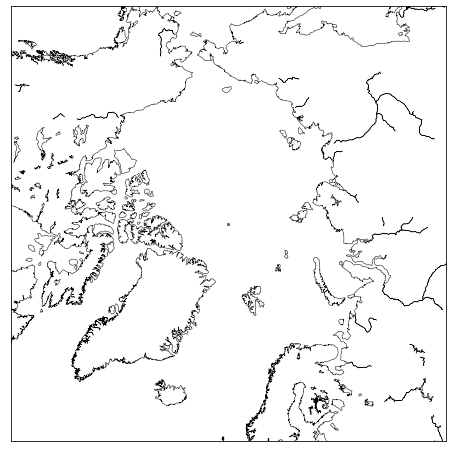

In [5]:
tracks_dict = pickle.load(open('trial_dict.p',"rb"))

plt.figure(figsize=(10,8))

timelist = list(range(365))

m = Basemap(projection='npstere',boundinglat=60,lon_0=360,resolution='l')
m.drawcoastlines(linewidth=0.5)
m.scatter(180,90,latlon=True,marker='x',s=5)

# for track in tracks_dict:
for year in np.arange(2010,2015,1):
    for track in all_tracks[year][0]:


        location_data = all_tracks[year][0][track][0]
        timestamp_data = all_tracks[year][0][track][1]

        wgslocs = []
        lons = []
        lats = []

        for loc in location_data:
            new = xy_to_lonlat(loc[0],loc[1])
            wgslocs.append(new)
            lons.append(new[0])
            lats.append(new[1])

        m.scatter(lons,lats,latlon=True,c=list(range(len(lons))),marker='.',s=10)

In [30]:
print(tracks_dict.keys())

dict_keys([(0.0, 80.97348408222669), (0.0, 85.49024393885045), (45.0, 83.62059331168996), (-90.0, 85.49024393885045), (180.0, 90.0), (90.0, 85.49024393885045), (-116.56505117707799, 79.90543092848388), (-135.0, 83.62059331168996), (180.0, 85.49024393885045), (135.0, 83.62059331168996), (116.56505117707799, 79.90543092848388), (-135.0, 77.22130733422003), (-153.434948822922, 79.90543092848388), (180.0, 80.97348408222669), (153.434948822922, 79.90543092848388), (180.0, 76.44261812808718)])


In [35]:
def process_track(dictionary,key):
    df = track_to_dataframe(dictionary,key)
    df_rean = add_reanalysis_to_track(df)
    df_rean_der = add_derived_vars_to_track(df_rean)
    smet_frame = create_smet(df_rean_der)
    save_smet_file(smet_frame)
    
# process_track(tracks_dict,(135.0, 83.62059331168996))
process_track(tracks_dict,(180.0, 76.44261812808718))

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessor

179.6-76.5-2015-10-01
File Written Successfully


In [19]:
ERA5_data = Dataset('test.nc')

ERA5_lon_grid = np.array([np.array(ERA5_data['longitude']),]*121)

ERA5_lat_grid = np.array([np.array(ERA5_data['latitude']),]*1440).T

ERA_x_grid, ERA_y_grid = lonlat_to_xy(ERA5_lon_grid,ERA5_lat_grid)

ERA_grid_points = list(zip(ERA_x_grid.ravel(),ERA_y_grid.ravel()))





In [20]:
def track_to_dataframe(dictionary,key):

    #Import a track

    track = dictionary[key]

    # Find the nearest gridded datapoint to your point in xy space

    distance,index = spatial.KDTree(ERA_grid_points).query(track[0])

    unraveled = np.unravel_index(index,(121,1440))

    df = pd.DataFrame({'location':track[0],
                    'ERA_x_ind':unraveled[0],
                    'ERA_y_ind':unraveled[1],
                      'date':track[1]})
    return(df)

In [21]:
def add_reanalysis_to_track(df):
    
    varlist = ['u10', 'v10', 't2m', 'ptype', 'asn', 'ssrd', 'strd', 'tp']

    list_of_dicts = []

    for daynum in range(len(df)):

        daystamp = df.iloc[daynum]['date']

        year = daystamp.year

        month = daystamp.month

        data = Dataset('ERA_forcings/ERA_'  +  str(year)  +  '_'  +  str(month).zfill(2)  +  '.nc')

        rh_data = Dataset('/media/robbie/Seagate Portable Drive/ERA5_3hr_reanalysis/ERA_'+str(year)+'_'+\
                          str(month).zfill(2)+'rh_.nc')

        for hour in np.arange(0,24,3):

            loc = df.iloc[daynum]['location']
            x_index = df.iloc[daynum]['ERA_x_ind']
            y_index = df.iloc[daynum]['ERA_y_ind']

            # Get the timestamp of the variable

            timestamp = daystamp + \
                        datetime.timedelta(hours=int(hour))

            day_of_month = timestamp.day       

            # Load the month's data

            dat_dic = {}

            dat_dic['loc'] = loc
            dat_dic['timestamp'] = timestamp

            for var in varlist:
                try:
                    dat_dic[var] = data[var][(8*(day_of_month-1))+hour/3][x_index][y_index]
                except:
                    print(timestamp)
            dat_dic['rh'] = rh_data['r'][(8*(day_of_month-1))+hour/3][x_index][y_index]

            list_of_dicts.append(dat_dic)

    df = pd.DataFrame(list_of_dicts)
    
    return(df)

In [29]:
def add_derived_vars_to_track(df):

    cum_precip = 0
    cum_precip_list = []

    ISO_timeseries_list = []

    wind_speed_list = []

    wind_dir_list = []

    for i in range(len(df['tp'])):

        cum_precip += df['tp'][i]
        cum_precip_list.append(cum_precip)

        model_date = date = df['timestamp'][i]

        ISO_timeseries_list.append(model_date.isoformat())

        wind_speed_list.append(sqrt((df['v10'][i]**2) + (df['u10'][i]**2)))

        wind_dir_list.append(np.degrees(np.arctan(df['u10'][i]/df['v10'][i])))

    df['cum_prec'] = cum_precip_list
    df['ISO_time'] = ISO_timeseries_list
    df['wind_speed'] = wind_speed_list
    df['wind_dir'] = wind_dir_list

    metadata = (np.round(xy_to_lonlat(df['loc'][0][0],
                                      df['loc'][0][1])
                         ,decimals=1),
                
                df['timestamp'][0].date() 
               )
    return(df,metadata)


In [26]:
def create_smet(full_data,hourly=True):
    
    df = full_data[0]
    metadata = full_data[1]

    TSG = np.full(len(df['ISO_time']),273.05)
    null = np.full(len(df['ISO_time']),-999)

    smet_frame =  pd.DataFrame({'timestamp':df['ISO_time'],
                                  'TA':df['t2m'],
                                  'RH':df['rh']/100,
                                  'TSG':TSG,
                                  'TSS_UNUSED':null,
                                  'HS_UNUSED':null,
                                  'VW':df['wind_speed'],
                                  'DW':df['wind_dir'],
                                  'OSWR_UNUSED':null,
                                  'ISWR':df['ssrd']/10800,
                                  'ILWR':df['strd']/10800,
                                  'PSUM':df['tp']*1000,
                                  'TS1':null,
                                  'TS2':null,
                                  'TS3':null})
    
    if hourly == True:
        
        hourly_records = []
    
        for rownum in range(len(smet_frame)):

            row0 = smet_frame.iloc[rownum]
            three_hr_psum = row0['PSUM'].copy()

            row0.set_value('PSUM', three_hr_psum/3)
            hourly_records.append(row0)


            row1 = row0.copy()
            time1 = reverser(smet_frame.iloc[rownum]['timestamp']) + datetime.timedelta(hours=1)
            row1.set_value('timestamp', time1.isoformat())
            row1.set_value('PSUM', three_hr_psum/3)
            hourly_records.append(row1)

            row2 = row0.copy()
            time2 = reverser(smet_frame.iloc[rownum]['timestamp']) + datetime.timedelta(hours=2)
            row2.set_value('timestamp', time2.isoformat())
            row2.set_value('PSUM', three_hr_psum/3)
            hourly_records.append(row2)


        smet_frame = pd.DataFrame.from_records(hourly_records)

    return(smet_frame,metadata)


In [24]:
def save_smet_file(data,read_back=False):
    
    smet_frame = data[0]
    meta_data = data[1]
    
    
    directory = "/home/robbie/Dropbox/Modelling/wever/smet/"
    filename = str(meta_data[0][0])+'-'+str(meta_data[0][1])+'-'+str(meta_data[1])
    file_extension = ".smet"
    
    print(filename)

    pd.set_option('display.float_format', lambda x: '%.5f' % x)

    preamble = f"""SMET 1.1 ASCII
[HEADER]
station_id = track_{filename}
latitude = {meta_data[0][1]}
longitude = {meta_data[0][0]}
altitude = 0
epsg = 21781
nodata = -999
tz = 1
source = Robbie Mallett CPOM UCL
fields = timestamp TA RH TSG TSS_UNUSED HS VW DW OSWR_UNUSED ISWR ILWR PSUM TS1 TS2 TS3
units_multiplier = 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[DATA]"""

    smet_frame = smet_frame.round(5)

    stringblock = smet_frame.to_string(header=None, index=None)
    
    f= open(directory+filename+file_extension,"w+",encoding='utf8')
    f.write(preamble+'\n')
    f.write(stringblock)

    f.close()
    if read_back==False:
        print('File Written Successfully')
    else:
        f= open(directory+filename+file_extension,"r")
        contents =f.read()
        print(contents)

# save_smet_file(smet_frame,read_back=True)

135.4-83.7-2015-10-01
SMET 1.1 ASCII
[HEADER]
station_id = track_135.4-83.7-2015-10-01
latitude = 83.7
longitude = 135.4
altitude = 0
epsg = 21781
nodata = -999
tz = 1
source = Robbie Mallett CPOM UCL
fields = timestamp TA RH TSG TSS_UNUSED HS VW DW OSWR_UNUSED ISWR ILWR PSUM TS1 TS2 TS3
units_multiplier = 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[DATA]
 2014-10-01T00:00:00 270.49465 0.96353 273.05000 -999 -999  6.96384 -86.33978 -999  20937.31097 1083670.32155  0.04023 -999 -999 -999
 2014-10-01T01:00:00 270.49465 0.96353 273.05000 -999 -999  6.96384 -86.33978 -999  20937.31097 1083670.32155  0.04023 -999 -999 -999
 2014-10-01T02:00:00 270.49465 0.96353 273.05000 -999 -999  6.96384 -86.33978 -999  20937.31097 1083670.32155  0.04023 -999 -999 -999
 2014-10-01T03:00:00 272.10502 0.93023 273.05000 -999 -999 10.03499 -81.46197 -999  88639.11910 1084151.91599  0.00540 -999 -999 -999
 2014-10-01T04:00:00 272.10502 0.93023 273.05000 -999 -999 10.03499 -81.46197 -999  88639.11910 1084151.91599  0.00540 